# Geometry module
This notebook demonstrates how to run the geometry module (GM) in two regimes: i) use the SGP4 backend to generate the navigation data (orbit positions and attitudes) and ii) import navigation data from AOCS simulations. In both regimes, the solar and viewing geometries are generated using TEDS geolocation routines as a second step.

This tutorial requires some auxiliary files which are available here: https://surfdrive.surf.nl/files/index.php/s/xs0PS5KyxvNxYTX.
Download the following files into the present directory:
* `ckd.nc` --- calibration key data containing the line-of-sight (LOS) vectors.
* `gebco_ocssw_v2020.nc` --- digital elevation model (DEM) with surface heights covering the whole Earth with 15-arcsecond steps. This is an optional input to geolocation for better accuracy.
* `aocs_navigation_truth.nc` --- Navigation data from AOCS simulations. Used as input for GM instead of the SGP4 library.
* `aocs_navigation_perturbed.nc` --- Navigation data from AOCS with realistic perturbations on the attitude quaternions. The orbit positions and timestamps remain the same as in the truth case.
* `ne_10m_land.shp`, `ne_10m_land.shx` --- world coastline map for plotting.

Furthermore, `PYTHONPATH` (`sys.path`) should point to the TEDS source directory and the TEDS virtual environment on your computer. Otherwise, the tutorial can be run as is by evaluating all cells.

In [1]:
import sys
# Add TEDS source directory and the Python virtual environment to PYTHONPATH
sys.path.append('/home/raul/builds/teds/venv/lib64/python3.12/site-packages/')
sys.path.append('/home/raul/Projects/tango/teds/dev/')

from datetime import datetime
from netCDF4 import Dataset
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import yaml

from teds.gm.gm import geometry_module
from teds.gm.vincenty import vincenty

## 1 - Generate geometry using TEDS
Below is a configuration file for generating navigation and geolocation data over a 30x30 km2 area around the Janschwalde power plant. Even though conceptually the GM is not at the instrument level, we need to specify the detector image integration time and take LOS vectors from the CKD in order to generate a realistic latitude/longitude grid (part of geolocation data). The total image capture period is 4.2 s. Generation of navigation data does not depend on instrument parameters.

In [2]:
conf = {
    'profile': 'orbit',
    'orbit': {
        'epoch': datetime.fromisoformat('2022-08-12T12:00:00'),
        'sat_height': 500.0,  # km
        'eccentricity': 0.0,
        'arg_perigee': 0.0,
        'mean_anomaly': 0.0,
        'ltan': 13.823,  # decimal hours
        'mean_motion_dot': 0.0,
        'drag_coeff': 0.0,
        'propagation_duration': 0.25  # hours
    },
    'sensor': {
        'integration_time': 0.04,  # seconds
        'start_time': 13.73,  # minutes wrt orbit epoch
        'end_time': 13.80,  # minutes wrt orbit epoch
    },
    'io_files': {
        'ckd': 'ckd.nc',
        'dem': 'gebco_ocssw_v2020.nc',
        'geometry': 'geometry.nc',
        'navigation': 'navigation.nc',
    }
}
geometry_module(conf)

[12:11:52] Generating detector image timestamps
[12:11:52] Generating orbit timestamps
[12:11:52] Generating satellite orbit


#########################
# Tango geometry module #
#########################
Version                 : 0.0.1
Commit hash             : 79503ab7
Date and timezone       : 2025 January 30 Thu
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.12.10-arch1-1



[12:11:53] Generating attitude quaternions
[12:11:53] Geolocation



###########
# Success #
###########


In order to visualize the entire simulated trajectory of the spacecraft, perform another simulation by artificially increasing detector integration time and the image capture period and then only look at the swath center latitudes and longitudes along the track. The instrument parameters have no meaning here --- this is just to get the ground track.

In [3]:
conf['sensor'] = {
    'integration_time': 1.0,  # seconds
    'start_time': 0.0,  # minutes wrt orbit epoch
    'end_time': 14.8,  # minutes wrt orbit epoch
}
conf['io_files']['geometry'] = 'geometry_full.nc'
geometry_module(conf)

[12:11:54] Generating detector image timestamps


#########################
# Tango geometry module #
#########################
Version                 : 0.0.1
Commit hash             : 79503ab7
Date and timezone       : 2025 January 30 Thu
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.12.10-arch1-1



[12:11:55] Generating orbit timestamps
[12:11:55] Generating satellite orbit
[12:11:56] Generating attitude quaternions
[12:11:56] Geolocation



###########
# Success #
###########


Now plot the ground track and the geolocation data in one figure. This is just to visualize the scene. The usage of GM products in other TEDS modules is as follows:
* `geometry.nc` --- latitudes and longitudes and the solar and viewing geometries. Used in the scene generation module (SGM) for generating a radiometric scene.
* `navigation.nc` --- navigation data (orbit positions and attitudes quaternions) used in the L1B processor for rederiving geolocation data.

(44.0, 58.0)

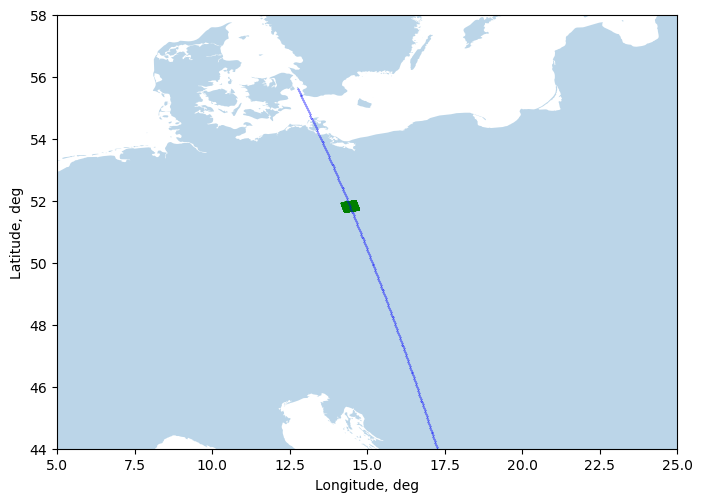

In [4]:
nc = Dataset('geometry.nc')
lat, lon = nc['longitude'][:].data, nc['latitude'][:].data
nc.close()

nc = Dataset('geometry_full.nc')
lat_mid, lon_mid = nc['longitude'][:].data, nc['latitude'][:].data
i_mid = lat_mid.shape[1] // 2
lat_mid, lon_mid = lat_mid[:, i_mid], lon_mid[:, i_mid]
nc.close()

fig, ax = plt.subplots(figsize=(8, 6))
world = gpd.read_file('ne_10m_land.shx')
world.plot(ax=ax, alpha=0.3)
ax.set_xlabel('Longitude, deg')
ax.set_ylabel('Latitude, deg')
ax.scatter(lat, lon, s=0.1, c='g')
ax.scatter(lat_mid, lon_mid, s=0.1, c='b')
ax.set_xlim(5, 25)
ax.set_ylim(44, 58)

## 2 - Generate geometry using AOCS navigation data
The "orbit" section in the configuration file gives us the freedom to target any area of interest. On the other hand, if navigation data from the AOCS orbit simulator for a particular scene is available, it can instead be used as input for GM, bypassing the generation of navigation data using the SPG4 library routines. The advantage of using AOCS is more realistic orbit simulation. In particular, AOCS is capable or producing attitude quaternions with or without realistic perturbations specific to the Tango platform.

Below is a configuration file with the "aocs_navigation" keyword pointing to a file containing the AOCS navigation data. We start with the truth case. Notice that the entire "orbit" section is gone because it is not used in this case. The integration time is the same as before and `start_time` refers to the beginning of the navigation data. `end_time` is set to 19.8 s (0.33 min) which is about 5 times longer than the first simulation. The reason is that unlike in the first simulation, a forward motion compensation (FMC) factor of 5 is encoded in the navigation data which results in a small rotation of the platform in order to stay more focused on the target scene. Thus, in order to cover the same 30 km ground distance along track as before, the image capture time needs to be longer.

In [5]:
conf = {
    'profile': 'orbit',
    'sensor': {
        'integration_time': 0.04,  # seconds
        'start_time': 0.0,  # minutes wrt orbit epoch
        'end_time': 0.33,  # minutes wrt orbit epoch
    },
    'io_files': {
        'aocs_navigation': 'aocs_navigation_truth.nc',
        'ckd': 'ckd.nc',
        'dem': 'gebco_ocssw_v2020.nc',
        'geometry': 'geometry_aocs_truth.nc',
        'navigation': 'navigation.nc',
    }
}
geometry_module(conf)

[12:12:03] Reading AOCS generated quaternions
[12:12:03] Generating detector image timestamps


#########################
# Tango geometry module #
#########################
Version                 : 0.0.1
Commit hash             : 79503ab7
Date and timezone       : 2025 January 30 Thu
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.12.10-arch1-1



[12:12:03] Generating orbit timestamps
[12:12:03] Geolocation



###########
# Success #
###########


Next, visualize the geolocation data from the first simulation (FMC=1) with that from the AOCS navigation data (FMC=5). Other than a different trajectory of the spacecraft, they cover a similar 30x30 km2 area around Janschwalde. The main difference is that the AOCS result has about 5 times as many bins along track.

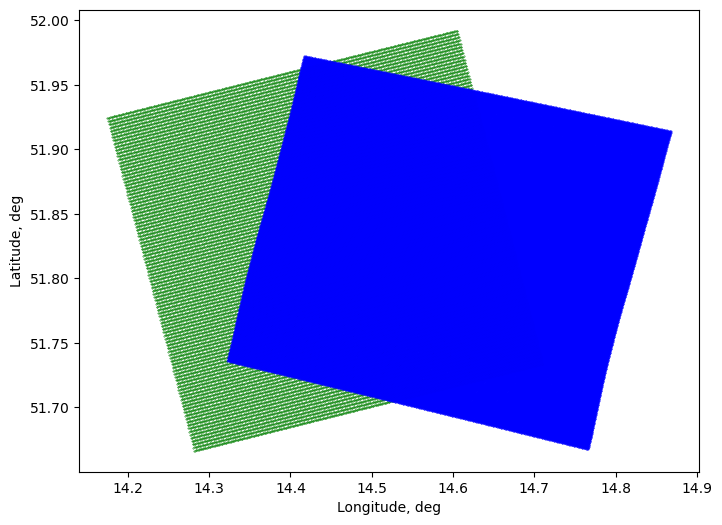

In [6]:
nc = Dataset('geometry.nc')
lat, lon = nc['longitude'][:].data, nc['latitude'][:].data
nc.close()

nc = Dataset('geometry_aocs_truth.nc')
lat_aocs, lon_aocs = nc['longitude'][:].data, nc['latitude'][:].data
nc.close()

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('Longitude, deg')
ax.set_ylabel('Latitude, deg')
ax.scatter(lat, lon, s=0.1, c='g')
ax.scatter(lat_aocs, lon_aocs, s=0.1, c='b')

Finally, redo the simulation using perturbed attitude quaternions as input.

In [7]:
conf['io_files']['aocs_navigation'] = 'aocs_navigation_perturbed.nc'
conf['io_files']['geometry'] = 'geometry_aocs_perturbed.nc'
geometry_module(conf)

[12:12:07] Reading AOCS generated quaternions
[12:12:07] Generating detector image timestamps


#########################
# Tango geometry module #
#########################
Version                 : 0.0.1
Commit hash             : 79503ab7
Date and timezone       : 2025 January 30 Thu
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.12.10-arch1-1



[12:12:07] Generating orbit timestamps
[12:12:07] Geolocation



###########
# Success #
###########


Define the geolocation error by computing distances between geolocation points from the truth and perturbed simulations. The error varies little across track which is expected because the simulated perturbations do not have LOS vector dependence. Along track, however, the error ranges from 50 m to 300 m, i.e. up to the extent of 1 L1B bin.

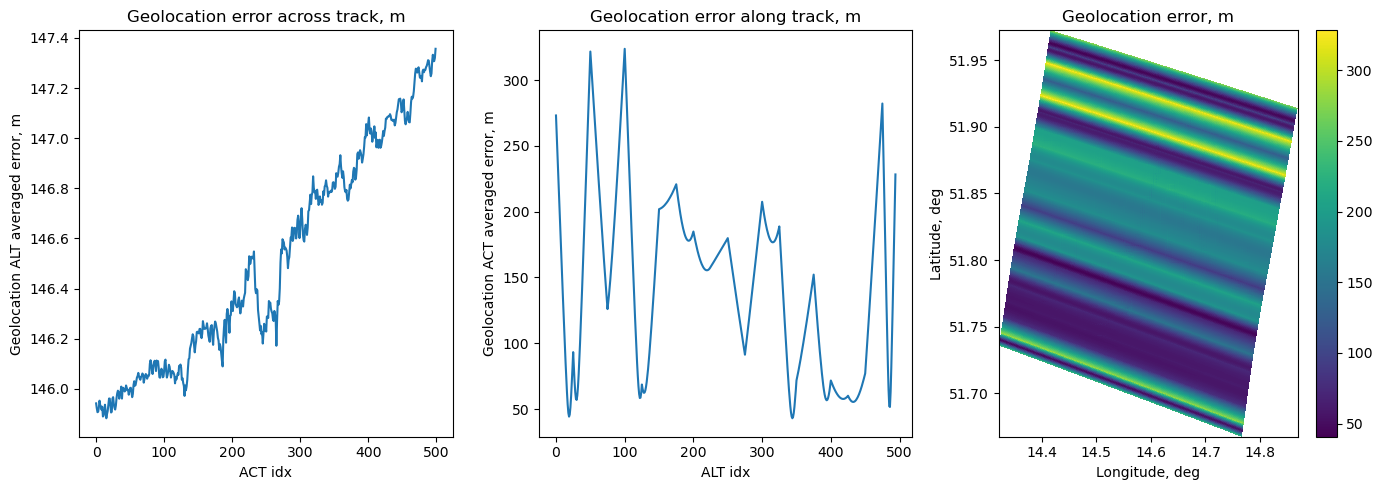

In [8]:
nc = Dataset('geometry_aocs_truth.nc')
lat_truth, lon_truth = nc['longitude'][:].data, nc['latitude'][:].data
nc.close()

nc = Dataset('geometry_aocs_perturbed.nc')
lat_pert, lon_pert = nc['longitude'][:].data, nc['latitude'][:].data
nc.close()

distances = vincenty(np.deg2rad(lat_truth), np.deg2rad(lat_pert),
                     np.deg2rad(lon_truth), np.deg2rad(lon_pert))

fig, axs = plt.subplots(1, 3, figsize=(14, 5))

ax = axs[0]
ax.plot(distances.mean(0))
ax.set_xlabel('ACT idx')
ax.set_ylabel('Geolocation ALT averaged error, m')
ax.set_title('Geolocation error across track, m')

ax = axs[1]
ax.plot(distances.mean(1))
ax.set_xlabel('ALT idx')
ax.set_ylabel('Geolocation ACT averaged error, m')
ax.set_title('Geolocation error along track, m')

ax = axs[2]
psm = ax.pcolormesh(lat_truth, lon_truth, distances)
fig.colorbar(psm, ax=ax)
ax.set_xlabel('Longitude, deg')
ax.set_ylabel('Latitude, deg')
ax.set_title('Geolocation error, m')

plt.tight_layout()